In [84]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import random
import datetime
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from scipy.stats import poisson
import lightgbm as lgb
%run functions.ipynb
from unidecode import unidecode
plt.rcParams['figure.figsize'] = [15, 8]
pd.set_option("display.precision", 3)

In [85]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.min_rows', 10)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(precision = 1, suppress = True)

In [86]:
opp_stats = pd.read_csv('opponent_stats',index_col=0)
schedule = pd.read_csv('schedule',index_col=0)
data = pd.read_csv('data_test.csv')

for i in range(1, 20):
    file_name = f"betting_lines_{i}"
    try:
        # Use globals() to dynamically set the variable name
        globals()[f"lines{i}"] = pd.read_csv(file_name, index_col=0)
        x = pd.read_csv(file_name, index_col=0)
        if i == 1:
            full = lines1
        else:
            full = pd.concat((full,x))
    except FileNotFoundError:
        notfound = file_name
        break
        
for m in range(3,5):
    for i in range(1, 30):
        file_name = f"lines{m}_{i}"
        yest_file = f"lines{m}_{i-1}"
        try:
            # Use globals() to dynamically set the variable name
            globals()[f"lines{m}_{i}"] = pd.read_csv(file_name, index_col=0)
            pp_today = pd.read_csv(file_name, index_col=0)
            pp_yesterday = pd.read_csv(yest_file, index_col=0)
            x = pd.read_csv(file_name, index_col=0)
            full = pd.concat((full,x))
        except FileNotFoundError:
            notfound = file_name

In [87]:
len(full)

12027

In [88]:
schedule = pd.read_csv('schedule',index_col=0)
schedule = schedule.reset_index(drop=True)
save = pd.read_csv('data.csv')

In [89]:
data=data[['Player','Pos', 'G', 'Date', 'Age', 'Tm', 'H/A', 'Opp', 'GS', 'W/L', 'MP',
       'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-','KM','PTS_miss']]
data.sample(2)

,Player,Pos,G,Date,Age,Tm,H/A,Opp,GS,W/L,...,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,KM,PTS_miss
9710,Austin Reaves,SG,41,2023-02-15,24-262,LAL,1,NOP,0,18,...,3,0,0,0,2,5,5.9,-1.0,5,90.180
6395,Norman Powell,SG,36,2023-01-17,29-237,LAC,1,PHI,0,-10,...,0,1,0,3,1,16,7.1,-15.0,8,111.708


In [90]:
def age2float(age):
    splt = age.split('-')
    return float(splt[0]) + (float(splt[1])/365)

data['Age'] = data.Age.apply(lambda x: age2float(x))
data

,Player,Pos,G,Date,Age,Tm,H/A,Opp,GS,W/L,...,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,KM,PTS_miss
0,Jayson Tatum,PF,1,2022-10-18,24.627,BOS,1,PHI,1,9,...,4,1,1,3,1,35,30.1,10.0,7,74.529
1,Jayson Tatum,PF,2,2022-10-21,24.636,BOS,0,MIA,1,7,...,4,1,2,2,1,29,22.7,-1.0,7,74.185
2,Jayson Tatum,PF,3,2022-10-22,24.638,BOS,0,ORL,1,6,...,1,1,2,1,2,40,34.2,6.0,7,72.439
3,Jayson Tatum,PF,4,2022-10-24,24.644,BOS,0,CHI,1,-18,...,5,0,0,1,2,26,20.7,-8.0,7,72.463
4,Jayson Tatum,PF,5,2022-10-28,24.655,BOS,1,CLE,1,-9,...,4,1,1,4,4,32,24.1,-10.0,7,74.497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25141,Marko Simonovic,C,3,2023-02-16,23.340,CHI,1,MIL,0,-12,...,0,0,0,0,1,0,-0.4,8.0,15,98.094
25142,Marko Simonovic,C,4,2023-03-31,23.458,CHI,0,CHA,0,30,...,0,0,0,0,1,0,-0.4,-1.0,15,94.275
25143,Marko Simonovic,C,5,2023-04-04,23.468,CHI,1,ATL,0,-18,...,0,0,0,0,0,2,1.0,0.0,15,94.398
25144,Marko Simonovic,C,6,2023-04-05,23.471,CHI,0,MIL,0,-13,...,0,0,0,0,0,0,0.0,3.0,15,86.403


In [91]:
POSIT = data['Pos'].to_list()
print(data['Pos'].unique())
pos_dict = {'PG':1, 'SG': '2','SF':3,'PF':4,'C':5,'PF-SF':4,'SF-SG':3,'SG-PG':2}
pos_i = []
for i in range(len(POSIT)):
    pos_i.append(pos_dict[POSIT[i]])
pos_i[0:10]

['PF' 'C' 'PG' 'SG' 'SF' 'PF-SF' 'SF-SG' 'SG-PG']


[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [92]:
data['Pos']=pos_i
data.sample(2)

,Player,Pos,G,Date,Age,Tm,H/A,Opp,GS,W/L,...,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,KM,PTS_miss
8990,Jusuf Nurkic,5,19,2022-11-30,28.271,POR,0,LAL,1,-19,...,1,1,1,2,3,8,5.0,-5.0,6,100.323
8365,Kelly Olynyk,5,38,2023-01-07,31.721,UTA,0,CHI,1,-8,...,2,0,2,1,5,6,2.9,-1.0,11,95.296


In [93]:
stats = data.copy(deep=True)

In [94]:
acron = save['Opp'].unique()
acron.sort()
acr2i = {a:i for i,a in enumerate(acron)}
acr2i
i2acr = {i:a for i,a in enumerate(acron)}

In [95]:
Opp = data['Opp'].to_list()
tm = data['Tm'].to_list()
opp_i = []
tm_i = []
for i in range(len(Opp)):
    opp_i.append(acr2i[Opp[i]])
    tm_i.append(acr2i[tm[i]])
    
data['Tm'] = tm_i
data['Opp'] = opp_i

In [96]:
data = data.drop(columns=['GmSc','+/-'])

In [97]:
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Rest'] = data.groupby('Player')['Date'].diff().dt.days
data.head(2)

,Player,Pos,G,Date,Age,Tm,H/A,Opp,GS,W/L,...,TRB,AST,STL,BLK,TOV,PF,PTS,KM,PTS_miss,Rest
0,Jayson Tatum,4,1,2022-10-18,24.627,2,1,22,1,9,...,12,4,1,1,3,1,35,7,74.529,NaN
1,Jayson Tatum,4,2,2022-10-21,24.636,2,0,15,1,7,...,5,4,1,2,2,1,29,7,74.185,3.0


In [98]:
data = data[['Player', 'Pos', 'G','Date','Age', 'Tm', 'H/A', 'Opp', 'GS','Rest', 'W/L', 'MP', 'FG',
       'FGA', 'FG%',  '3PA', '3P%', 'PF', 'FTA', 'FT%', 'ORB', 'DRB', 'FT','3P',
        'STL', 'BLK', 'TOV','TRB', 'AST', 'PTS','KM','PTS_miss']]
data.sample(2)

,Player,Pos,G,Date,Age,Tm,H/A,Opp,GS,Rest,...,FT,3P,STL,BLK,TOV,TRB,AST,PTS,KM,PTS_miss
9007,Jusuf Nurkic,5,36,2023-01-12,28.389,24,1,5,1,2.0,...,0,0,1,0,4,12,4,12,6,75.830
21696,Amir Coffey,2,12,2022-11-14,25.411,12,0,10,0,2.0,...,0,0,0,0,1,1,2,0,9,123.258


In [99]:
players = data['Player']
p2i = {p:i for i,p in enumerate(players.unique())}

play_i = []
for i in range(len(players)):
    play_i.append(p2i[players[i]])
data['Player'] = play_i

In [100]:
i2p = {i:p for i,p in enumerate(players.unique())}

In [101]:
data = data.fillna(2)

In [102]:
data.columns

Index(['Player', 'Pos', 'G', 'Date', 'Age', 'Tm', 'H/A', 'Opp', 'GS', 'Rest',
       'W/L', 'MP', 'FG', 'FGA', 'FG%', '3PA', '3P%', 'PF', 'FTA', 'FT%',
       'ORB', 'DRB', 'FT', '3P', 'STL', 'BLK', 'TOV', 'TRB', 'AST', 'PTS',
       'KM', 'PTS_miss'],
      dtype='object')

In [103]:
#data[['Player', 'Pos', 'G', 'Date', 'Tm', 'H/A', 'Opp', 'GS', 'Rest', 'W/L',
#       'MP', 'FG', 'FGA', 'FG%', '3PA', '3P%', 'PF', 'FTA', 'FT%', 'ORB',
#       'DRB', 'FT', '3P', 'STL', 'BLK', 'TOV', 'TRB', 'AST', 'PTS']] = data.astype('float64')
data.sample(2)

,Player,Pos,G,Date,Age,Tm,H/A,Opp,GS,Rest,...,FT,3P,STL,BLK,TOV,TRB,AST,PTS,KM,PTS_miss
11088,165,2,4,2022-10-24,29.107,26,0,17,0,2.0,...,0,1,1,0,0,3,1,9,5,92.751
11187,166,3,40,2023-01-20,31.047,26,1,12,0,3.0,...,0,0,0,0,1,0,0,2,5,97.266


In [104]:
opp_stats['EFG%'] = (opp_stats['FGM']+ (0.5 * opp_stats['3P']))/opp_stats['FGA']
opp_stats.sort_values(by='EFG%')

,Team,GP,PTS,FGM,FGA,FG%,3P,3PA,3P%,FT,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,EFG%
5,MIL,67,111.9,41.8,92.9,45.0,11.7,33.8,34.5,16.6,...,78.0,10.9,33.6,44.5,22.9,7.2,4.0,11.7,19.0,0.513
4,MEM,66,111.9,40.2,89.6,44.9,12.8,36.3,35.3,18.7,...,78.7,11.2,33.5,44.7,26.2,6.9,5.2,14.7,20.7,0.520
8,NYK,69,112.4,40.4,88.7,45.6,12.9,37.1,34.6,18.7,...,78.0,10.7,32.3,42.9,24.7,6.0,4.5,11.9,20.9,0.528
11,BKN,67,112.9,40.9,88.5,46.2,12.1,32.5,37.1,19.1,...,76.2,11.4,33.6,45.0,23.1,7.2,3.9,13.2,18.4,0.531
7,BOS,68,112.4,42.0,90.1,46.6,11.7,33.3,35.2,16.6,...,77.4,9.6,34.3,43.9,22.9,6.6,3.9,12.0,19.4,0.531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,DET,68,118.9,43.4,88.4,49.1,12.1,33.1,36.4,20.1,...,77.8,10.9,33.9,44.8,25.7,7.5,5.5,13.4,21.4,0.559
27,HOU,67,118.5,42.3,88.2,47.9,14.7,39.1,37.6,19.2,...,79.8,10.5,31.1,41.6,25.9,8.9,6.1,12.8,21.0,0.563
26,SAC,66,118.3,44.0,89.0,49.5,12.3,33.2,37.1,18.0,...,78.9,9.7,32.1,41.8,26.3,7.5,4.0,13.8,21.2,0.563
6,TOR,68,112.2,40.6,82.5,49.2,12.4,32.8,37.7,18.6,...,79.7,9.3,33.2,42.5,26.2,6.2,4.6,15.9,20.2,0.567


In [105]:
opp_stats= opp_stats[['Team','PTS','FGA','3PA','FTA','TOV','EFG%']]
opp_stats
tm_idx = []
for i in opp_stats.Team.values:
    tm_idx.append(acr2i[i])
opp_stats['tm_idx'] = tm_idx
opp_stats


,Team,PTS,FGA,3PA,FTA,TOV,EFG%,tm_idx
0,CLE,106.6,83.6,30.9,22.2,14.5,0.533,5
1,MIA,109.4,83.2,35.6,21.3,15.3,0.557,15
2,PHI,111.0,85.1,33.0,24.0,13.8,0.542,22
3,PHX,111.2,85.7,32.2,25.3,13.8,0.532,23
4,MEM,111.9,89.6,36.3,23.8,14.7,0.520,14
...,...,...,...,...,...,...,...,...
25,IND,117.9,88.6,33.2,25.7,14.6,0.549,11
26,SAC,118.3,89.0,33.2,22.8,13.8,0.563,25
27,HOU,118.5,88.2,39.1,24.1,12.8,0.563,10
28,DET,118.9,88.4,33.1,25.8,13.4,0.559,8


In [106]:
data = pd.merge(data, opp_stats, left_on='Tm', right_on='tm_idx',suffixes = ('','_opp'))
data = data.drop(['Team','tm_idx',],axis=1)
data.columns

Index(['Player', 'Pos', 'G', 'Date', 'Age', 'Tm', 'H/A', 'Opp', 'GS', 'Rest',
       'W/L', 'MP', 'FG', 'FGA', 'FG%', '3PA', '3P%', 'PF', 'FTA', 'FT%',
       'ORB', 'DRB', 'FT', '3P', 'STL', 'BLK', 'TOV', 'TRB', 'AST', 'PTS',
       'KM', 'PTS_miss', 'PTS_opp', 'FGA_opp', '3PA_opp', 'FTA_opp', 'TOV_opp',
       'EFG%'],
      dtype='object')

In [107]:
def feature_eng(df,stat):
    
    ppm = df[stat]/df['MP']
    df['ppm'] = ppm
    test = df.groupby(['Player']).ewm(alpha=0.1)['ppm'].mean().shift().reset_index()
    df['ppm'] = test['ppm']
    
    test = df.groupby(['Player']).ewm(alpha=0.1)['ppm'].mean().shift().reset_index()
    df['ppm_emw'] = test['ppm']
    
    test = df.groupby(['Player']).ewm(alpha=0.1)[stat].mean().shift().reset_index()
    df['Pts_emw'] = test[stat]
    mp = df.groupby(['Player']).ewm(alpha=0.2)['MP'].mean().shift().reset_index()
    df['MP_emw'] = mp['MP']

    test = df.groupby(['Player']).rolling(10,min_periods=1)[stat].mean().shift().reset_index()
    df['Pts_roll'] = test[stat]
    
    mp = df.groupby(['Player']).rolling(2,min_periods=1)['MP'].mean().shift().reset_index()
    df['MP_roll_2'] = mp['MP']
    
    mp4 = df.groupby(['Player']).rolling(4,min_periods=1)['MP'].mean().shift().reset_index()
    df['MP_diff'] = mp4['MP']-mp['MP']
    
    pt_dev = df.groupby(['Player']).rolling(5,min_periods=1).std()[stat].shift().reset_index()
    df['Pts_sd'] = pt_dev[stat]
    MP_std = df.groupby(['Player']).rolling(5,min_periods=2).std()['MP'].shift().reset_index()
    df['MP_std'] = MP_std['MP']
    return df

In [108]:
data = feature_eng(data,'PTS')
data.sample(2)

C:\Users\User\AppData\Local\Temp\ipykernel_11800\2191467944.py:25: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  pt_dev = df.groupby(['Player']).rolling(5,min_periods=1).std()[stat].shift().reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_11800\2191467944.py:27: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  MP_std = df.groupby(['Player']).rolling(5,min_periods=2).std()['MP'].shift().reset_index()


,Player,Pos,G,Date,Age,Tm,H/A,Opp,GS,Rest,...,EFG%,ppm,ppm_emw,Pts_emw,MP_emw,Pts_roll,MP_roll_2,MP_diff,Pts_sd,MP_std
10889,396,3,46,2023-03-29,29.967,28,0,26,1,2.0,...,0.541,0.257,0.429,9.352,36.673,9.25,36.383,0.171,2.217,2.181
81,13,3,9,2022-11-05,26.033,2,0,19,1,1.0,...,0.531,0.822,0.604,28.029,33.944,27.75,34.233,0.175,3.564,3.863


In [109]:
data.columns

Index(['Player', 'Pos', 'G', 'Date', 'Age', 'Tm', 'H/A', 'Opp', 'GS', 'Rest',
       'W/L', 'MP', 'FG', 'FGA', 'FG%', '3PA', '3P%', 'PF', 'FTA', 'FT%',
       'ORB', 'DRB', 'FT', '3P', 'STL', 'BLK', 'TOV', 'TRB', 'AST', 'PTS',
       'KM', 'PTS_miss', 'PTS_opp', 'FGA_opp', '3PA_opp', 'FTA_opp', 'TOV_opp',
       'EFG%', 'ppm', 'ppm_emw', 'Pts_emw', 'MP_emw', 'Pts_roll', 'MP_roll_2',
       'MP_diff', 'Pts_sd', 'MP_std'],
      dtype='object')

In [110]:

tens = data.drop(['FG', 'FGA', 'FG%', '3PA', '3P%', 'PF', 'FTA', 'FT%', 'ORB', 'DRB',
       'FT', '3P', 'STL', 'BLK', 'TOV', 'TRB', 'AST'],axis=1)
tens = tens.apply(np.array)
tens.sample(3)

,Player,Pos,G,Date,Age,Tm,H/A,Opp,GS,Rest,...,EFG%,ppm,ppm_emw,Pts_emw,MP_emw,Pts_roll,MP_roll_2,MP_diff,Pts_sd,MP_std
24593,152,3,19,2022-12-04,23.134,11,0,24,1,2.0,...,0.549,0.259,0.172,6.316,23.054,6.5,23.333,0.000,4.950,3.559
9491,74,2,56,2023-02-24,24.496,25,0,12,1,1.0,...,0.563,0.336,0.266,10.214,29.443,10.1,32.092,-2.133,7.956,9.019
8911,261,5,48,2023-02-26,29.548,4,1,29,0,2.0,...,0.542,0.413,0.293,13.327,32.327,12.5,34.600,-3.029,3.362,5.346


In [111]:
tens.drop(['W/L','MP','PTS'],axis=1).head(3)

,Player,Pos,G,Date,Age,Tm,H/A,Opp,GS,Rest,...,EFG%,ppm,ppm_emw,Pts_emw,MP_emw,Pts_roll,MP_roll_2,MP_diff,Pts_sd,MP_std
0,0,4,1,2022-10-18,24.627,2,1,22,1,2.0,...,0.531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,4,2,2022-10-21,24.636,2,0,15,1,3.0,...,0.531,0.906,NaN,35.000,38.633,35.0,38.633,0.0,NaN,NaN
2,0,4,3,2022-10-22,24.638,2,0,21,1,1.0,...,0.531,0.844,0.906,31.842,37.606,32.0,37.708,0.0,4.243,1.308


In [112]:
tens.columns

Index(['Player', 'Pos', 'G', 'Date', 'Age', 'Tm', 'H/A', 'Opp', 'GS', 'Rest',
       'W/L', 'MP', 'PTS', 'KM', 'PTS_miss', 'PTS_opp', 'FGA_opp', '3PA_opp',
       'FTA_opp', 'TOV_opp', 'EFG%', 'ppm', 'ppm_emw', 'Pts_emw', 'MP_emw',
       'Pts_roll', 'MP_roll_2', 'MP_diff', 'Pts_sd', 'MP_std'],
      dtype='object')

In [113]:
#tens = tens.dropna()
X = tens.drop(['W/L','MP','PTS'],axis=1)
Y = tens['PTS']

In [114]:
X[['Player', 'Pos', 'G', 'Tm', 'H/A', 'Opp', 'GS','KM']] = X[['Player', 'Pos', 'G', 'Tm', 'H/A', 'Opp', 'GS','KM']].astype(int)
X = X.copy(deep=True)

In [115]:
X.sort_values(by='Date').head(3)

,Player,Pos,G,Date,Age,Tm,H/A,Opp,GS,Rest,...,EFG%,ppm,ppm_emw,Pts_emw,MP_emw,Pts_roll,MP_roll_2,MP_diff,Pts_sd,MP_std
0,0,4,1,2022-10-18,24.627,2,1,22,1,2.0,...,0.531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1328,289,5,1,2022-10-18,28.726,22,0,2,0,2.0,...,0.542,0.679,0.635,25.808,38.286,25.667,38.433,-0.544,2.082,3.560
19276,396,3,1,2022-10-18,29.523,13,0,9,0,2.0,...,0.535,0.320,0.295,5.832,14.551,7.200,13.592,-0.096,5.215,4.056


In [116]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42)
X_train = X.loc[X.Date < '2023-03-15'].drop(['G','Date'],axis=1)
X_test = X.loc[X.Date > '2023-03-16'].drop(['G','Date'],axis=1)
y_train = tens.loc[tens.Date < '2023-03-15'].PTS
y_test =  tens.loc[tens.Date > '2023-03-16'].PTS

In [117]:
X_train.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'H/A', 'Opp', 'GS', 'Rest', 'KM',
       'PTS_miss', 'PTS_opp', 'FGA_opp', '3PA_opp', 'FTA_opp', 'TOV_opp',
       'EFG%', 'ppm', 'ppm_emw', 'Pts_emw', 'MP_emw', 'Pts_roll', 'MP_roll_2',
       'MP_diff', 'Pts_sd', 'MP_std'],
      dtype='object')

In [118]:
X_train.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'H/A', 'Opp', 'GS', 'Rest', 'KM',
       'PTS_miss', 'PTS_opp', 'FGA_opp', '3PA_opp', 'FTA_opp', 'TOV_opp',
       'EFG%', 'ppm', 'ppm_emw', 'Pts_emw', 'MP_emw', 'Pts_roll', 'MP_roll_2',
       'MP_diff', 'Pts_sd', 'MP_std'],
      dtype='object')

In [119]:
import lightgbm as lgb

In [120]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2','poisson'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 5,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 10000
}

In [121]:
gbm = lgb.LGBMRegressor(**hyper_params)

In [122]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l2',
        early_stopping_rounds=1000)

C:\Users\User\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM

[119]	valid_0's l1: 5.77653	valid_0's l2: 53.6301	valid_0's poisson: -16.7561
[120]	valid_0's l1: 5.76866	valid_0's l2: 53.4967	valid_0's poisson: -16.7617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's l1: 5.76063	valid_0's l2: 53.3597	valid_0's poisson: -16.7675
[122]	valid_0's l1: 5.75267	valid_0's l2: 53.2223	valid_0's poisson: -16.7733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's l1: 5.74486	valid_0's l2: 53.0874	valid_0's poisson: -16.779
[124]	valid_0's l1: 5.73703	valid_0's l2: 52.953	valid_0's poisson: -16.7846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's l1: 5.72932	valid_0's l2: 52.8202	valid_0's poisson: -16.7902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's l1: 5.72177	valid_0's l2: 52.69	valid_0's poisson: -16.7957
[127]	valid_0's l1: 5.71457	valid_0's l2: 52.5688	valid_0's poisson: -16.8011
[1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's l1: 5.28581	valid_0's l2: 45.7108	valid_0's poisson: -17.0966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's l1: 5.28191	valid_0's l2: 45.6543	valid_0's poisson: -17.0992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's l1: 5.27811	valid_0's l2: 45.5994	valid_0's poisson: -17.1016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's l1: 5.27423	valid_0's l2: 45.5436	valid_0's poisson: -17.1041
[209]	valid_0's l1: 5.27044	valid_0's l2: 45.4873	valid_0's poisson: -17.1067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's l1: 5.26675	valid_0's l2: 45.4339	valid_0's poisson: -17.1091
[211]	valid_0's l1: 5.26272	valid_0's l2: 45.3748	valid_0's poisson: -17.1117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212

[294]	valid_0's l1: 5.01837	valid_0's l2: 42.1031	valid_0's poisson: -17.261
[295]	valid_0's l1: 5.01632	valid_0's l2: 42.0777	valid_0's poisson: -17.2621
[296]	valid_0's l1: 5.01414	valid_0's l2: 42.0511	valid_0's poisson: -17.2633
[297]	valid_0's l1: 5.01214	valid_0's l2: 42.0263	valid_0's poisson: -17.2645
[298]	valid_0's l1: 5.01013	valid_0's l2: 42.0017	valid_0's poisson: -17.2656
[299]	valid_0's l1: 5.00814	valid_0's l2: 41.9771	valid_0's poisson: -17.2667
[300]	valid_0's l1: 5.00616	valid_0's l2: 41.9523	valid_0's poisson: -17.2678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[301]	valid_0's l1: 5.00419	valid_0's l2: 41.9291	valid_0's poisson: -17.2689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[302]	valid_0's l1: 5.00225	valid_0's l2: 41.9062	valid_0's poisson: -17.27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[303]	valid_0's l1: 5.00034	valid_0's l2: 41.8842	valid_0's poisson: -17.271

[376]	valid_0's l1: 4.89269	valid_0's l2: 40.6602	valid_0's poisson: -17.33
[377]	valid_0's l1: 4.89176	valid_0's l2: 40.6504	valid_0's poisson: -17.3305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's l1: 4.89062	valid_0's l2: 40.636	valid_0's poisson: -17.3312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's l1: 4.88971	valid_0's l2: 40.6254	valid_0's poisson: -17.3317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's l1: 4.88864	valid_0's l2: 40.6133	valid_0's poisson: -17.3323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	valid_0's l1: 4.88755	valid_0's l2: 40.5997	valid_0's poisson: -17.333
[382]	valid_0's l1: 4.88644	valid_0's l2: 40.5858	valid_0's poisson: -17.3337
[383]	valid_0's l1: 4.88534	valid_0's l2: 40.5729	valid_0's poisson: -17.3344
[384]	valid_0's l1: 4.88419	valid_0's l2: 40.5579	valid_0's poisson: -17.3352
[3

[456]	valid_0's l1: 4.82292	valid_0's l2: 39.8905	valid_0's poisson: -17.3682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[457]	valid_0's l1: 4.82244	valid_0's l2: 39.8859	valid_0's poisson: -17.3685
[458]	valid_0's l1: 4.8218	valid_0's l2: 39.8783	valid_0's poisson: -17.3689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	valid_0's l1: 4.82124	valid_0's l2: 39.873	valid_0's poisson: -17.3691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[460]	valid_0's l1: 4.82065	valid_0's l2: 39.8678	valid_0's poisson: -17.3694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[461]	valid_0's l1: 4.82001	valid_0's l2: 39.8629	valid_0's poisson: -17.3696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[462]	valid_0's l1: 4.81929	valid_0's l2: 39.8549	valid_0's poisson: -17.37
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[463]	va

[526]	valid_0's l1: 4.78719	valid_0's l2: 39.5329	valid_0's poisson: -17.3854
[527]	valid_0's l1: 4.78677	valid_0's l2: 39.5288	valid_0's poisson: -17.3857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[528]	valid_0's l1: 4.78631	valid_0's l2: 39.5243	valid_0's poisson: -17.3859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[529]	valid_0's l1: 4.78582	valid_0's l2: 39.5197	valid_0's poisson: -17.3861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[530]	valid_0's l1: 4.78536	valid_0's l2: 39.5153	valid_0's poisson: -17.3863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[531]	valid_0's l1: 4.78502	valid_0's l2: 39.5122	valid_0's poisson: -17.3865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[532]	valid_0's l1: 4.7846	valid_0's l2: 39.5091	valid_0's poisson: -17.3866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[533]

[604]	valid_0's l1: 4.76308	valid_0's l2: 39.2959	valid_0's poisson: -17.3981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	valid_0's l1: 4.76294	valid_0's l2: 39.2946	valid_0's poisson: -17.3981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's l1: 4.76279	valid_0's l2: 39.2937	valid_0's poisson: -17.3982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's l1: 4.76269	valid_0's l2: 39.2929	valid_0's poisson: -17.3982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's l1: 4.76242	valid_0's l2: 39.2914	valid_0's poisson: -17.3982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's l1: 4.76209	valid_0's l2: 39.2896	valid_0's poisson: -17.3983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	valid_0's l1: 4.76185	valid_0's l2: 39.2878	valid_0's poisson: -17.3984
[Lig

[694]	valid_0's l1: 4.74447	valid_0's l2: 39.1169	valid_0's poisson: -17.4072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[695]	valid_0's l1: 4.74452	valid_0's l2: 39.1177	valid_0's poisson: -17.4071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[696]	valid_0's l1: 4.74453	valid_0's l2: 39.118	valid_0's poisson: -17.4071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[697]	valid_0's l1: 4.74435	valid_0's l2: 39.1157	valid_0's poisson: -17.4072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[698]	valid_0's l1: 4.74438	valid_0's l2: 39.1164	valid_0's poisson: -17.4071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[699]	valid_0's l1: 4.74411	valid_0's l2: 39.1132	valid_0's poisson: -17.4073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	valid_0's l1: 4.74406	valid_0's l2: 39.112	valid_0's poisson: -17.4073
[Light

[781]	valid_0's l1: 4.73526	valid_0's l2: 38.9996	valid_0's poisson: -17.412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[782]	valid_0's l1: 4.73512	valid_0's l2: 38.9984	valid_0's poisson: -17.4121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[783]	valid_0's l1: 4.73489	valid_0's l2: 38.9952	valid_0's poisson: -17.4122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[784]	valid_0's l1: 4.73463	valid_0's l2: 38.9921	valid_0's poisson: -17.4124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[785]	valid_0's l1: 4.73438	valid_0's l2: 38.9888	valid_0's poisson: -17.4125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[786]	valid_0's l1: 4.73416	valid_0's l2: 38.9857	valid_0's poisson: -17.4127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[787]	valid_0's l1: 4.73394	valid_0's l2: 38.983	valid_0's poisson: -17.4128
[Light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[855]	valid_0's l1: 4.7289	valid_0's l2: 38.9219	valid_0's poisson: -17.4147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[856]	valid_0's l1: 4.72901	valid_0's l2: 38.9238	valid_0's poisson: -17.4147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[857]	valid_0's l1: 4.72899	valid_0's l2: 38.9231	valid_0's poisson: -17.4147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[858]	valid_0's l1: 4.72886	valid_0's l2: 38.9215	valid_0's poisson: -17.4147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[859]	valid_0's l1: 4.72883	valid_0's l2: 38.9211	valid_0's poisson: -17.4147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[860]	valid_0's l1: 4.72874	valid_0's l2: 38.92	valid_0's poisson: -17.4147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[861]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[957]	valid_0's l1: 4.72335	valid_0's l2: 38.8467	valid_0's poisson: -17.4184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[958]	valid_0's l1: 4.72336	valid_0's l2: 38.8467	valid_0's poisson: -17.4184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[959]	valid_0's l1: 4.72347	valid_0's l2: 38.8478	valid_0's poisson: -17.4184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[960]	valid_0's l1: 4.72345	valid_0's l2: 38.8479	valid_0's poisson: -17.4184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[961]	valid_0's l1: 4.72328	valid_0's l2: 38.8447	valid_0's poisson: -17.4186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[962]	valid_0's l1: 4.72317	valid_0's l2: 38.8422	valid_0's poisson: -17.4187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[963]	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1055]	valid_0's l1: 4.72187	valid_0's l2: 38.8239	valid_0's poisson: -17.4204
[1056]	valid_0's l1: 4.72193	valid_0's l2: 38.8239	valid_0's poisson: -17.4204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1057]	valid_0's l1: 4.72195	valid_0's l2: 38.8236	valid_0's poisson: -17.4204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1058]	valid_0's l1: 4.72198	valid_0's l2: 38.8228	valid_0's poisson: -17.4204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1059]	valid_0's l1: 4.72203	valid_0's l2: 38.8222	valid_0's poisson: -17.4205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1060]	valid_0's l1: 4.72206	valid_0's l2: 38.8222	valid_0's poisson: -17.4205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1061]	valid_0's l1: 4.72204	valid_0's l2: 38.8221	valid_0's poisson: -17.42

[1155]	valid_0's l1: 4.71972	valid_0's l2: 38.7713	valid_0's poisson: -17.4227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1156]	valid_0's l1: 4.71962	valid_0's l2: 38.7697	valid_0's poisson: -17.4228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1157]	valid_0's l1: 4.71954	valid_0's l2: 38.7681	valid_0's poisson: -17.4229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1158]	valid_0's l1: 4.71957	valid_0's l2: 38.7674	valid_0's poisson: -17.423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1159]	valid_0's l1: 4.7195	valid_0's l2: 38.7653	valid_0's poisson: -17.4231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1160]	valid_0's l1: 4.7195	valid_0's l2: 38.7646	valid_0's poisson: -17.4231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1161]	valid_0's l1: 4.71947	valid_0's l2: 38.7635	valid_0's poisson: -17.4231


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1212]	valid_0's l1: 4.72035	valid_0's l2: 38.7593	valid_0's poisson: -17.4225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1213]	valid_0's l1: 4.7203	valid_0's l2: 38.7587	valid_0's poisson: -17.4225
[1214]	valid_0's l1: 4.72038	valid_0's l2: 38.7591	valid_0's poisson: -17.4225
[1215]	valid_0's l1: 4.72046	valid_0's l2: 38.7594	valid_0's poisson: -17.4225
[1216]	valid_0's l1: 4.72044	valid_0's l2: 38.7592	valid_0's poisson: -17.4224
[1217]	valid_0's l1: 4.72054	valid_0's l2: 38.7597	valid_0's poisson: -17.4224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1218]	valid_0's l1: 4.72062	valid_0's l2: 38.7606	valid_0's poisson: -17.4223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1219]	valid_0's l1: 4.72075	valid_0's l2: 38.7617	valid_0's poisson: -17.4222
[1220]	valid_0's l1: 4.72084	valid_0's l2: 38.7621	valid_0's poisson:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1320]	valid_0's l1: 4.71977	valid_0's l2: 38.7447	valid_0's poisson: -17.4222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1321]	valid_0's l1: 4.71968	valid_0's l2: 38.7427	valid_0's poisson: -17.4224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1322]	valid_0's l1: 4.71972	valid_0's l2: 38.7434	valid_0's poisson: -17.4223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1323]	valid_0's l1: 4.71964	valid_0's l2: 38.7422	valid_0's poisson: -17.4224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1324]	valid_0's l1: 4.71952	valid_0's l2: 38.7409	valid_0's poisson: -17.4225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1325]	valid_0's l1: 4.71946	valid_0's l2: 38.7404	valid_0's poisson: -17.4226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[1376]	valid_0's l1: 4.71809	valid_0's l2: 38.7265	valid_0's poisson: -17.4231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1377]	valid_0's l1: 4.71797	valid_0's l2: 38.7252	valid_0's poisson: -17.4231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1378]	valid_0's l1: 4.71794	valid_0's l2: 38.7247	valid_0's poisson: -17.4232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1379]	valid_0's l1: 4.71793	valid_0's l2: 38.7244	valid_0's poisson: -17.4232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1380]	valid_0's l1: 4.71786	valid_0's l2: 38.7235	valid_0's poisson: -17.4232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1381]	valid_0's l1: 4.71785	valid_0's l2: 38.7227	valid_0's poisson: -17.4233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1382]	valid_0's l1: 4.71777	valid_0's l2: 38.7215	valid_0's poisson: -17.42

[1432]	valid_0's l1: 4.71743	valid_0's l2: 38.7175	valid_0's poisson: -17.4237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1433]	valid_0's l1: 4.71731	valid_0's l2: 38.7162	valid_0's poisson: -17.4238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1434]	valid_0's l1: 4.71718	valid_0's l2: 38.7152	valid_0's poisson: -17.4239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1435]	valid_0's l1: 4.71707	valid_0's l2: 38.7141	valid_0's poisson: -17.4239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1436]	valid_0's l1: 4.71703	valid_0's l2: 38.7138	valid_0's poisson: -17.4239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1437]	valid_0's l1: 4.71699	valid_0's l2: 38.7138	valid_0's poisson: -17.4239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1438]	valid_0's l1: 4.71699	valid_0's l2: 38.7139	valid_0's poisson: -17.42

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1489]	valid_0's l1: 4.71651	valid_0's l2: 38.7055	valid_0's poisson: -17.4243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1490]	valid_0's l1: 4.71651	valid_0's l2: 38.7054	valid_0's poisson: -17.4243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1491]	valid_0's l1: 4.71644	valid_0's l2: 38.7045	valid_0's poisson: -17.4244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1492]	valid_0's l1: 4.71632	valid_0's l2: 38.703	valid_0's poisson: -17.4244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1493]	valid_0's l1: 4.71624	valid_0's l2: 38.7025	valid_0's poisson: -17.4245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1494]	valid_0's l1: 4.71609	valid_0's l2: 38.7012	valid_0's poisson: -17.4245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1

[1590]	valid_0's l1: 4.7144	valid_0's l2: 38.657	valid_0's poisson: -17.4258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1591]	valid_0's l1: 4.71447	valid_0's l2: 38.6573	valid_0's poisson: -17.4257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1592]	valid_0's l1: 4.71454	valid_0's l2: 38.6574	valid_0's poisson: -17.4257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1593]	valid_0's l1: 4.7145	valid_0's l2: 38.6551	valid_0's poisson: -17.4257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1594]	valid_0's l1: 4.71458	valid_0's l2: 38.6562	valid_0's poisson: -17.4257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1595]	valid_0's l1: 4.71462	valid_0's l2: 38.6565	valid_0's poisson: -17.4256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1596]	valid_0's l1: 4.71459	valid_0's l2: 38.6551	valid_0's poisson: -17.4257


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1646]	valid_0's l1: 4.71298	valid_0's l2: 38.6328	valid_0's poisson: -17.4262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1647]	valid_0's l1: 4.71302	valid_0's l2: 38.633	valid_0's poisson: -17.4262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1648]	valid_0's l1: 4.71298	valid_0's l2: 38.6324	valid_0's poisson: -17.4262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1649]	valid_0's l1: 4.71296	valid_0's l2: 38.6319	valid_0's poisson: -17.4262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1650]	valid_0's l1: 4.71298	valid_0's l2: 38.6322	valid_0's poisson: -17.4262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1651]	valid_0's l1: 4.71304	valid_0's l2: 38.6326	valid_0's poisson: -17.4261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1

[1704]	valid_0's l1: 4.71299	valid_0's l2: 38.6267	valid_0's poisson: -17.426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1705]	valid_0's l1: 4.71298	valid_0's l2: 38.6269	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1706]	valid_0's l1: 4.713	valid_0's l2: 38.6272	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1707]	valid_0's l1: 4.71296	valid_0's l2: 38.6269	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1708]	valid_0's l1: 4.71295	valid_0's l2: 38.6271	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1709]	valid_0's l1: 4.71292	valid_0's l2: 38.6263	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1710]	valid_0's l1: 4.71289	valid_0's l2: 38.6258	valid_0's poisson: -17.4259


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1758]	valid_0's l1: 4.71266	valid_0's l2: 38.62	valid_0's poisson: -17.426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1759]	valid_0's l1: 4.71267	valid_0's l2: 38.6202	valid_0's poisson: -17.426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1760]	valid_0's l1: 4.71266	valid_0's l2: 38.62	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1761]	valid_0's l1: 4.71269	valid_0's l2: 38.6206	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1762]	valid_0's l1: 4.71268	valid_0's l2: 38.6206	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1763]	valid_0's l1: 4.71263	valid_0's l2: 38.62	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1764]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1843]	valid_0's l1: 4.71068	valid_0's l2: 38.5912	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1844]	valid_0's l1: 4.71069	valid_0's l2: 38.5919	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1845]	valid_0's l1: 4.71073	valid_0's l2: 38.5925	valid_0's poisson: -17.4258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1846]	valid_0's l1: 4.71076	valid_0's l2: 38.5931	valid_0's poisson: -17.4258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1847]	valid_0's l1: 4.71074	valid_0's l2: 38.5932	valid_0's poisson: -17.4258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1848]	valid_0's l1: 4.71079	valid_0's l2: 38.5938	valid_0's poisson: -17.4258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1903]	valid_0's l1: 4.71099	valid_0's l2: 38.5973	valid_0's poisson: -17.4255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1904]	valid_0's l1: 4.711	valid_0's l2: 38.5976	valid_0's poisson: -17.4255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1905]	valid_0's l1: 4.71105	valid_0's l2: 38.5981	valid_0's poisson: -17.4255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1906]	valid_0's l1: 4.71106	valid_0's l2: 38.5984	valid_0's poisson: -17.4255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1907]	valid_0's l1: 4.71109	valid_0's l2: 38.599	valid_0's poisson: -17.4255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1908]	valid_0's l1: 4.7111	valid_0's l2: 38.599	valid_0's poisson: -17.4255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1909]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1959]	valid_0's l1: 4.71094	valid_0's l2: 38.6045	valid_0's poisson: -17.4252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1960]	valid_0's l1: 4.71094	valid_0's l2: 38.6048	valid_0's poisson: -17.4252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1961]	valid_0's l1: 4.71092	valid_0's l2: 38.6038	valid_0's poisson: -17.4252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1962]	valid_0's l1: 4.71086	valid_0's l2: 38.6028	valid_0's poisson: -17.4253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1963]	valid_0's l1: 4.71079	valid_0's l2: 38.6015	valid_0's poisson: -17.4254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1964]	valid_0's l1: 4.71076	valid_0's l2: 38.6008	valid_0's poisson: -17.4255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[2061]	valid_0's l1: 4.71018	valid_0's l2: 38.5891	valid_0's poisson: -17.4262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2062]	valid_0's l1: 4.71018	valid_0's l2: 38.5894	valid_0's poisson: -17.4261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2063]	valid_0's l1: 4.7102	valid_0's l2: 38.5899	valid_0's poisson: -17.426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2064]	valid_0's l1: 4.71021	valid_0's l2: 38.5899	valid_0's poisson: -17.426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2065]	valid_0's l1: 4.71026	valid_0's l2: 38.5906	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2066]	valid_0's l1: 4.7103	valid_0's l2: 38.5913	valid_0's poisson: -17.4259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2067]	valid_0's l1: 4.71031	valid_0's l2: 38.5915	valid_0's poisson: -17.4258
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2118]	valid_0's l1: 4.7099	valid_0's l2: 38.5962	valid_0's poisson: -17.4255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2119]	valid_0's l1: 4.70996	valid_0's l2: 38.5966	valid_0's poisson: -17.4255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2120]	valid_0's l1: 4.70996	valid_0's l2: 38.5977	valid_0's poisson: -17.4255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2121]	valid_0's l1: 4.71	valid_0's l2: 38.5985	valid_0's poisson: -17.4254
[2122]	valid_0's l1: 4.71009	valid_0's l2: 38.5994	valid_0's poisson: -17.4254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2123]	valid_0's l1: 4.7101	valid_0's l2: 38.5998	valid_0's poisson: -17.4254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2124]	valid_0's l1: 4.71011	valid_0's l2: 38.6001	valid_0's poisson: -17.4254
[L

[2233]	valid_0's l1: 4.70959	valid_0's l2: 38.6015	valid_0's poisson: -17.4251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2234]	valid_0's l1: 4.70961	valid_0's l2: 38.6013	valid_0's poisson: -17.4251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2235]	valid_0's l1: 4.70963	valid_0's l2: 38.6012	valid_0's poisson: -17.4251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2236]	valid_0's l1: 4.70969	valid_0's l2: 38.6021	valid_0's poisson: -17.425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2237]	valid_0's l1: 4.70971	valid_0's l2: 38.6019	valid_0's poisson: -17.425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2238]	valid_0's l1: 4.70977	valid_0's l2: 38.603	valid_0's poisson: -17.425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2239]	valid_0's l1: 4.70978	valid_0's l2: 38.6029	valid_0's poisson: -17.425
[L

[2291]	valid_0's l1: 4.70957	valid_0's l2: 38.6032	valid_0's poisson: -17.4253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2292]	valid_0's l1: 4.70951	valid_0's l2: 38.6017	valid_0's poisson: -17.4254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2293]	valid_0's l1: 4.70951	valid_0's l2: 38.6008	valid_0's poisson: -17.4254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2294]	valid_0's l1: 4.70952	valid_0's l2: 38.6008	valid_0's poisson: -17.4253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2295]	valid_0's l1: 4.70952	valid_0's l2: 38.5998	valid_0's poisson: -17.4253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2296]	valid_0's l1: 4.70953	valid_0's l2: 38.6	valid_0's poisson: -17.4253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2297]	valid_0's l1: 4.70945	valid_0's l2: 38.5986	valid_0's poisson: -17.4254


[2351]	valid_0's l1: 4.70984	valid_0's l2: 38.6037	valid_0's poisson: -17.4244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2352]	valid_0's l1: 4.70987	valid_0's l2: 38.6038	valid_0's poisson: -17.4243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2353]	valid_0's l1: 4.70988	valid_0's l2: 38.6041	valid_0's poisson: -17.4243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2354]	valid_0's l1: 4.70991	valid_0's l2: 38.6044	valid_0's poisson: -17.4243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2355]	valid_0's l1: 4.70995	valid_0's l2: 38.6047	valid_0's poisson: -17.4243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2356]	valid_0's l1: 4.70998	valid_0's l2: 38.6049	valid_0's poisson: -17.4243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2357]	valid_0's l1: 4.71002	valid_0's l2: 38.6052	valid_0's poisson: -17.42

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2413]	valid_0's l1: 4.70975	valid_0's l2: 38.6002	valid_0's poisson: -17.4243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2414]	valid_0's l1: 4.70982	valid_0's l2: 38.6014	valid_0's poisson: -17.4242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2415]	valid_0's l1: 4.70979	valid_0's l2: 38.6009	valid_0's poisson: -17.4243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2416]	valid_0's l1: 4.70975	valid_0's l2: 38.6006	valid_0's poisson: -17.4244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2417]	valid_0's l1: 4.70971	valid_0's l2: 38.6	valid_0's poisson: -17.4244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2418]	valid_0's l1: 4.70971	valid_0's l2: 38.6004	valid_0's poisson: -17.4244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241

[2474]	valid_0's l1: 4.70903	valid_0's l2: 38.5947	valid_0's poisson: -17.4244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2475]	valid_0's l1: 4.70902	valid_0's l2: 38.5944	valid_0's poisson: -17.4244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2476]	valid_0's l1: 4.70902	valid_0's l2: 38.5945	valid_0's poisson: -17.4245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2477]	valid_0's l1: 4.70905	valid_0's l2: 38.5945	valid_0's poisson: -17.4245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2478]	valid_0's l1: 4.70905	valid_0's l2: 38.5944	valid_0's poisson: -17.4245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2479]	valid_0's l1: 4.70904	valid_0's l2: 38.5943	valid_0's poisson: -17.4245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2480]	valid_0's l1: 4.70902	valid_0's l2: 38.594	valid_0's poisson: -17.424

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2533]	valid_0's l1: 4.70928	valid_0's l2: 38.5992	valid_0's poisson: -17.4235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2534]	valid_0's l1: 4.70928	valid_0's l2: 38.5989	valid_0's poisson: -17.4235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2535]	valid_0's l1: 4.70929	valid_0's l2: 38.5982	valid_0's poisson: -17.4235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2536]	valid_0's l1: 4.7094	valid_0's l2: 38.5991	valid_0's poisson: -17.4234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2537]	valid_0's l1: 4.70934	valid_0's l2: 38.5974	valid_0's poisson: -17.4233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2538]	valid_0's l1: 4.70931	valid_0's l2: 38.5965	valid_0's poisson: -17.4233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2597]	valid_0's l1: 4.71022	valid_0's l2: 38.6021	valid_0's poisson: -17.4229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2598]	valid_0's l1: 4.7102	valid_0's l2: 38.6021	valid_0's poisson: -17.4228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2599]	valid_0's l1: 4.7102	valid_0's l2: 38.6024	valid_0's poisson: -17.4227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2600]	valid_0's l1: 4.71017	valid_0's l2: 38.6022	valid_0's poisson: -17.4227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2601]	valid_0's l1: 4.71017	valid_0's l2: 38.6023	valid_0's poisson: -17.4226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2602]	valid_0's l1: 4.71019	valid_0's l2: 38.6025	valid_0's poisson: -17.4226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26

[2665]	valid_0's l1: 4.71177	valid_0's l2: 38.6075	valid_0's poisson: -17.4212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2666]	valid_0's l1: 4.71172	valid_0's l2: 38.6071	valid_0's poisson: -17.4212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2667]	valid_0's l1: 4.71176	valid_0's l2: 38.6074	valid_0's poisson: -17.4211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2668]	valid_0's l1: 4.71168	valid_0's l2: 38.6069	valid_0's poisson: -17.4212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2669]	valid_0's l1: 4.71168	valid_0's l2: 38.6071	valid_0's poisson: -17.4211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2670]	valid_0's l1: 4.71165	valid_0's l2: 38.6071	valid_0's poisson: -17.4211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2671]	valid_0's l1: 4.7116	valid_0's l2: 38.606	valid_0's poisson: -17.4211

LGBMRegressor(bagging_fraction=0.9, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=5,
              metric=['l1', 'l2', 'poisson'], num_iterations=10000,
              num_leaves=128, objective='regression', task='train', verbose=0)

features: 'Player', 'Pos', 'G', 'Tm', 'H/A', 'Opp', 'GS', 'Rest', 'KM', 'Pts_emw','Pts_sd']
l1 = 4.573
l2 = 35.5963
add opp_pts
l1 = 4.5667
l2 = 35.4881
add mp_emw
l1 = 4.565
l2 = 35.5736
add mp_std
l1 = 4.532
l2 = 35.00
switch to poisson
l1 = 4.512
l2 = 34.796
add more another mp rolling and pts diff alpha
l1 = 4.415
l2 = 32.866

In [123]:
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
from sklearn.metrics import mean_squared_log_error
print('The rmse of prediction is:', round(mean_squared_log_error(y_pred, y_train) ** 0.5, 5))

The rmse of prediction is: 0.70338


In [124]:
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
y_pred

array([34.8, 30.1, 32. , ...,  2.6,  3.6,  1.2])

In [125]:
pp_today = pp_today.loc[~pp_today.Player.str.contains('\+')]
pp_today.loc[pp_today.Stat=='PTS']

,Player,Team,Line,Stat,League,Date
28,Bam Adebayo,CHI,19.0,PTS,7,2023-04-14
48,DeMar DeRozan,MIA,23.0,PTS,7,2023-04-14
49,Jimmy Butler,CHI,26.5,PTS,7,2023-04-14
61,Nikola Vucevic,MIA,16.0,PTS,7,2023-04-14
73,Tyler Herro,CHI,19.5,PTS,7,2023-04-14
...,...,...,...,...,...,...
627,Deandre Ayton,LAC,16.0,PTS,7,2023-04-16
628,Norman Powell,PHX,17.5,PTS,7,2023-04-16
640,Chris Paul,LAC,13.5,PTS,7,2023-04-16
643,Eric Gordon,PHX,10.5,PTS,7,2023-04-16


In [126]:
pp_today = pp_today[pp_today.Player != 'Xavier Tillman']
pp_today = pp_today.reset_index(drop=True)

In [138]:
#pt_lines = pp_today[pp_today.Stat=='PTS']
fullpts = full.loc[full.Date > '2023-03-16']
fullpts = fullpts.loc[fullpts.Stat=='PTS']
fullpts = fullpts[['Player','Team','Line','Stat','Date']]
fullpts

pt_lines=fullpts
pt_lines = pt_lines.loc[~pt_lines.Player.str.contains('\+')]
pt_lines = pt_lines[pt_lines.Player != 'Xavier Tillman'].reset_index(drop=True).copy(deep=True)
pt_lines_2 = pt_lines

#pp_today = pp_today.loc[~pp_today.Player.str.contains('\+')]
#pt_lines = pp_today.loc[pp_today.Stat=='PTS'].reset_index(drop=True)
len(pt_lines)

866

In [140]:
#%%timeit
stats_full = tens.drop('Date',axis=1).copy(deep=True)

pt_preds=[]

for i in range(len(pt_lines)):
#for i in range(2):

    #player,pos,g,Tm,H/A,Opp,GS,Rest,KM
    p = pt_lines.Player[i]
    date = pt_lines.Date[i]
    g = stats.loc[stats.Player==p].reset_index().tail(1)
    rest = int(date[-2:])-int(g.Date.values[0][-2:])
    team = g['Tm'].values[0]
    today = schedule.loc[schedule.Date==date]
    if team in today.Visitor.values:
        home = 0
    if team in today.Home.values:
        home = 1
    g['Rest'] = rest
    v = g[['Player','Pos','G','Tm','H/A','Opp','GS','Rest','KM']].copy(deep=True)
    v['H/A'] = home
    v['Player'] = p2i[v['Player'].values[0]]
    v['Tm'] = acr2i[v['Tm'].values[0]]
    v['Opp'] = acr2i[v['Opp'].values[0]]
    v = pd.merge(v,opp_stats, left_on='Tm', right_on='tm_idx',suffixes = ('','_opp'))
    v = v.drop(['Team','tm_idx','FGA', '3PA', 'FTA', 'TOV'],axis=1)
    
    stats_x = stats_full.loc[stats_full.Player==p2i[p]].reset_index(drop=True).sort_values(by='G').copy(deep=True)
    stats_x = pd.concat([stats_x,v])
    #stats_x = stats_x.append(v).reset_index(drop=True)
    stats_x = feature_eng(stats_x,'PTS')
    p_x = stats_x.copy(deep=True)
    p_x = stats_x.drop(['W/L','MP','PTS'],axis=1)
    p_x[['Player', 'Pos', 'G', 'Tm', 'H/A', 'Opp', 'GS','KM']] = p_x[['Player', 'Pos', 'G', 'Tm', 'H/A', 'Opp', 'GS','KM']].astype(int)
    pred = gbm.predict(p_x.drop(['G'],axis=1), num_iteration=gbm.best_iteration_)
    if i % 10 == 0:
        print('----',i,'/',len(pt_lines),'----')
        print(p)
        print(pred[-1])
    pt_preds.append(pred[-1])

    

---- 0 / 866 ----
Joel Embiid
32.57681912385516
---- 10 / 866 ----
Trae Young
30.52666684652259
---- 20 / 866 ----
Donovan Mitchell
28.188568045699338
---- 30 / 866 ----
Jalen Green
20.736605609386658
---- 40 / 866 ----
Desmond Bane
17.79458256557866
---- 50 / 866 ----
Anthony Edwards
29.81362459804399
---- 60 / 866 ----
Anfernee Simons
18.632779386811197
---- 70 / 866 ----
Paolo Banchero
17.755559887808623
---- 80 / 866 ----
Tyrese Maxey
18.22197079166496
---- 90 / 866 ----
Jimmy Butler
19.214492075859294
---- 100 / 866 ----
Josh Giddey
13.788281862007139
---- 110 / 866 ----
CJ McCollum
17.54430668038637
---- 120 / 866 ----
Anthony Davis
17.970425759107815
---- 130 / 866 ----
Nikola Vucevic
16.133269439196248
---- 140 / 866 ----
Paolo Banchero
17.15595910205266
---- 150 / 866 ----
James Wiseman
8.603344875668862
---- 160 / 866 ----
Brandon Ingram
19.628882094819748
---- 170 / 866 ----
Harrison Barnes
14.069581344378962
---- 180 / 866 ----
Shai Gilgeous-Alexander
31.568548313130425
---

In [141]:
pt_lines['Pred'] = pt_preds
pt_lines['Prob'] = 1- poisson.cdf(mu=pt_lines['Pred'],k=pt_lines['Line'])
pt_lines.loc[pt_lines.Team=='OKC'].sort_values(by='Prob')

,Player,Team,Line,Stat,Date,Pred,Prob
795,Karl-Anthony Towns,OKC,23.5,PTS,2023-04-14,10.063,1.316e-04
718,Karl-Anthony Towns,OKC,23.5,PTS,2023-04-14,10.063,1.316e-04
366,Austin Reaves,OKC,19.0,PTS,2023-03-24,9.333,1.607e-03
97,Devin Booker,OKC,31.5,PTS,2023-03-19,20.259,9.588e-03
363,Anthony Davis,OKC,27.5,PTS,2023-03-24,17.349,1.128e-02
...,...,...,...,...,...,...,...
296,Marcus Morris,OKC,10.5,PTS,2023-03-23,10.674,5.006e-01
365,Jarred Vanderbilt,OKC,7.5,PTS,2023-03-24,7.749,5.115e-01
179,Russell Westbrook,OKC,13.5,PTS,2023-03-21,14.336,5.707e-01
716,Anthony Edwards,OKC,27.5,PTS,2023-04-14,30.403,6.930e-01


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

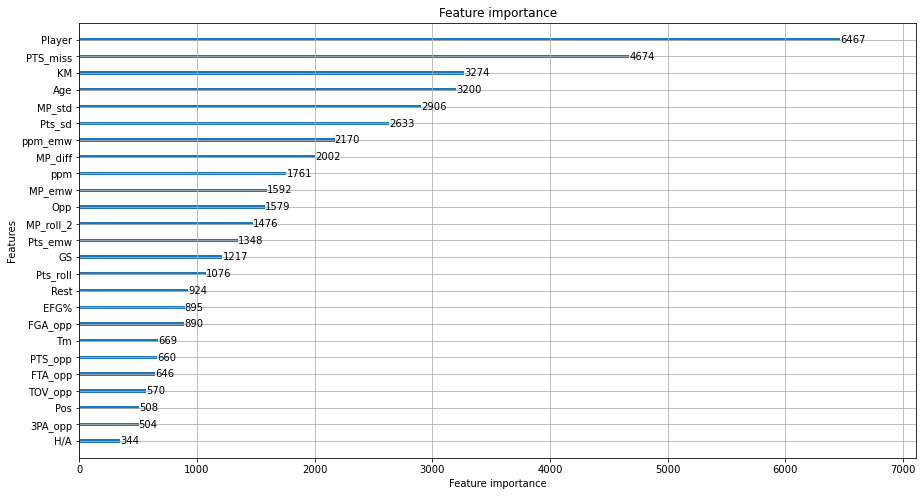

In [142]:
lgb.plot_importance(gbm, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='Feature importance', ylabel='Features', importance_type='auto', max_num_features=None, ignore_zero=True, figsize=None, dpi=None, grid=True, precision=3)

In [143]:
data2 = pd.read_csv('data.csv')

In [144]:
def check(lines):
    val = []
    everything = []
    err = 0
    date = lines['Date'].iloc[0]
    avail = data2.loc[data2['Date']< date]
    for i in range(len(lines)):
        if i%10 == 0:
            print(i)
        player = lines['Player'].iloc[i]
        date = lines['Date'].iloc[i]
        cat = lines['Stat'].iloc[i]
        line = lines['Line'].iloc[i]
        opp = lines['Team'].iloc[i]
        game  = get_game(player,date,stats=data2)
        expect = lines['Pred'].iloc[i]
        expect = (expect + adjust(player,cat,opp,stats=avail))/2
        
        if game.empty:
            print('err',player)
            err += 1
        else:
            km = game.KM.values[0]
            x = get_stat(player,cat,game)
            pred_diff = expect-line
            diff_real = x-line
            if np.sign(pred_diff) == np.sign(diff_real):
                val=1
            else:
                val=0
            pred_diff = x-expect
            #season = float(print_prob(player,line,cat,stats=avail,prnt=False))
            #l_10 = float(print_prob(player,line,cat,games=10,stats=avail,prnt=False))
            
            everything.append((player,opp,cat,expect,line,x[0],pred_diff,diff_real[0],val,km))
            
    x = np.array(everything,dtype=object)
    df = pd.DataFrame(x,columns=['Player','opp','Stat','pred','line','actual','pred_diff','diff_real','Win','km'])
    numeric = ['pred','line','actual','pred_diff','diff_real','Win']
    df[numeric]=df[numeric].astype(float)
    df['Prob']= 1- poisson.cdf(mu=df['pred'],k=df['line'])
    return df

In [55]:
pt_lines.loc[pt_lines.Team =='CHI']

,Player,Team,Line,Stat,League,Date,Pred,Prob
0,Bam Adebayo,CHI,19.0,PTS,7,2023-04-14,21.366,0.645
2,Jimmy Butler,CHI,26.5,PTS,7,2023-04-14,21.385,0.135
4,Tyler Herro,CHI,19.5,PTS,7,2023-04-14,18.568,0.400
8,Max Strus,CHI,9.5,PTS,7,2023-04-14,15.611,0.948


In [145]:
argh = check(pt_lines)
argh

0
10
20
30
40
50
60
70
err James Harden
80
90
100
110
120
130
140
150
160
err Keldon Johnson
170
180
190
200
210
220
230
240
250
260
err Jalen Brunson
270
280
290
300
310
320
330
340
350
360
err Myles Turner
370
380
390
400
410
420
430
err Giannis Antetokounmpo
440
450
460
470
480
err Dennis Smith Jr.
490
500
510
520
530
540
550
560
err RJ Barrett
570
580
590
600
610
620
630
640
err Franz Wagner
err Markelle Fultz
err Paolo Banchero
err Wendell Carter Jr.
err Bam Adebayo
err James Harden
err Jimmy Butler
err Joel Embiid
err Tyler Herro
650
err Malaki Branham
err Zach Collins
err Jalen Williams
err Josh Giddey
err Ochai Agbaji
err Shai Gilgeous-Alexander
err Alperen Sengun
err Jabari Smith Jr.
err Jalen Green
err Bryce McGowens
660
err Kenyon Martin Jr.
err Kevin Porter Jr.
err Svi Mykhailiuk
err JT Thor
err Corey Kispert
err Daniel Gafford
err Johnny Davis
err Aaron Nesmith
err Jaden Ivey
err Bennedict Mathurin
670
err Killian Hayes
err James Wiseman
err Cameron Johnson
err Dorian Finn

,Player,opp,Stat,pred,line,actual,pred_diff,diff_real,Win,km,Prob
0,Joel Embiid,CHA,PTS,34.619,34.5,38.0,3.381,3.5,1.0,7,0.497
1,Kelly Oubre Jr.,PHI,PTS,19.542,21.5,11.0,-8.542,-10.5,1.0,2,0.318
2,James Harden,CHA,PTS,22.015,22.5,11.0,-11.015,-11.5,1.0,3,0.445
3,Terry Rozier,PHI,PTS,19.551,21.5,14.0,-5.551,-7.5,1.0,2,0.319
4,Tyrese Maxey,CHA,PTS,19.401,20.5,13.0,-6.401,-7.5,1.0,2,0.388
...,...,...,...,...,...,...,...,...,...,...,...
629,Ivica Zubac,LAL,PTS,11.435,10.5,17.0,5.565,6.5,1.0,13,0.591
630,Anthony Davis,LAC,PTS,22.490,27.5,17.0,-5.490,-10.5,1.0,10,0.146
631,Russell Westbrook,LAL,PTS,14.638,17.0,14.0,-0.638,-3.0,1.0,0,0.221
632,Mason Plumlee,LAL,PTS,9.539,6.5,4.0,-5.539,-2.5,0.0,15,0.838


In [146]:
argh.sort_values(by='Prob')

,Player,opp,Stat,pred,line,actual,pred_diff,diff_real,Win,km,Prob
540,Shaedon Sharpe,MIN,PTS,7.878,23.5,27.0,19.122,3.5,0.0,1,2.891e-06
557,Deni Avdija,NYK,PTS,7.548,15.5,9.0,1.452,-6.5,1.0,12,4.883e-03
260,Bismack Biyombo,LAL,PTS,2.610,6.5,6.0,3.390,-0.5,1.0,15,1.751e-02
354,Bismack Biyombo,SAC,PTS,2.659,6.5,6.0,3.341,-0.5,1.0,15,1.914e-02
300,Deni Avdija,SAS,PTS,8.467,14.0,21.0,12.533,7.0,0.0,12,2.664e-02
...,...,...,...,...,...,...,...,...,...,...,...
458,Saddiq Bey,CLE,PTS,12.172,9.5,11.0,-1.172,1.5,1.0,8,7.723e-01
571,De'Aaron Fox,SAS,PTS,27.601,23.5,28.0,0.399,4.5,1.0,3,7.789e-01
602,Grayson Allen,PHI,PTS,11.356,8.5,2.0,-9.356,-6.5,0.0,5,7.981e-01
632,Mason Plumlee,LAL,PTS,9.539,6.5,4.0,-5.539,-2.5,0.0,15,8.380e-01


In [147]:
argh.loc[argh.Player=='Brandon Ingram']

,Player,opp,Stat,pred,line,actual,pred_diff,diff_real,Win,km,Prob
29,Brandon Ingram,HOU,PTS,22.682,25.5,31.0,8.318,5.5,0.0,3,0.269
107,Brandon Ingram,HOU,PTS,22.596,26.5,26.0,3.404,-0.5,1.0,3,0.202
159,Brandon Ingram,SAS,PTS,22.531,26.5,32.0,9.469,5.5,0.0,3,0.198
279,Brandon Ingram,CHA,PTS,20.787,27.5,30.0,9.213,2.5,0.0,3,0.075
382,Brandon Ingram,LAC,PTS,20.213,26.5,32.0,11.787,5.5,0.0,3,0.085
444,Brandon Ingram,POR,PTS,21.244,26.5,29.0,7.756,2.5,0.0,3,0.129
488,Brandon Ingram,GSW,PTS,20.501,27.0,26.0,5.499,-1.0,1.0,3,0.066
607,Brandon Ingram,MEM,PTS,20.510,28.5,24.0,3.490,-4.5,1.0,3,0.045


In [148]:
o = argh.loc[(argh.Prob<0.3) & (argh.Prob >0.15)]
u = argh.loc[(argh.Prob>0.7) & (argh.Prob < 0.9)]
print(len(u),len(o))
pd.concat((o,u)).mean()

18 141


C:\Users\User\AppData\Local\Temp\ipykernel_11800\487919679.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat((o,u)).mean()


pred         14.859
line         16.796
actual       17.925
pred_diff     3.065
diff_real     1.129
Win           0.528
km            6.094
Prob          0.297
dtype: float64

In [ ]:
o.mean()

In [ ]:
print('pred',abs(argh['pred_diff']).mean())
print('book',abs(argh['diff_real']).mean())

In [ ]:
len(argh.loc[argh.diff_real<0])

In [ ]:
plt.hist(argh['Prob'],bins=20, range=(0, 1))

In [ ]:
lgb.plot_metric(gbm,metric='l2')

In [ ]:
gbm.booster_.save_model('light')

In [ ]:
open('light')